# Building Network Models

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainpy/brainpy/blob/master/docs_version2/tutorial_building/build_network_models.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brainpy/brainpy/blob/master/docs_version2/tutorial_building/build_network_models.ipynb)

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn) @[Chaoming Wang](https://github.com/chaoming0625)

In previous sections, it has been illustrated how to define neuron models by `brainpy.dyn.NeuDyn` and synapse models by `brainpy.synapases.TwoEndConn`. This section will introduce `brainpy.DynSysGroup` (alias as `brainpy.Network` in the previous version of BrainPy), which is the base class used to build network models.

In essence, [brainpy.DynSysGroup](https://brainpy.readthedocs.io/en/latest/apis/generated/brainpy.DynSysGroup.html#brainpy.DynSysGroup) is a container, whose function is to compose the individual elements. 

In below, we take an excitation-inhibition (E-I) balanced network model as an example to illustrate how to compose the LIF neurons and Exponential synapses defined in previous tutorials to build a network. 

In [1]:
import numpy as np

import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

bp.__version__

'3.0.0'

## Excitation-Inhibition (E-I) Balanced Network

The E-I balanced network was first proposed to explain the irregular firing patterns of cortical neurons and comfirmed by experimental data. The network [1] we are going to implement consists of excitatory (E) neurons and inhibitory (I) neurons, the ratio of which is about 4 : 1. The biggest difference between excitatory and inhibitory neurons is the reversal potential - the reversal potential of inhibitory neurons is much lower than that of excitatory neurons. Besides, the membrane time constant of inhibitory neurons is longer than that of excitatory neurons, which indicates that inhibitory neurons have slower dynamics.

[1] Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98.

Before defining the E/I balanced network, we first define the Exponential synapse model we need.

In [2]:
class Exponential(bp.Projection):
    def __init__(self, pre, post, prob, g_max, tau, E=0.):
        super().__init__()
        self.proj = bp.dyn.ProjAlignPostMg2(
            pre=pre,
            delay=None,
            comm=bp.dnn.EventCSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
            syn=bp.dyn.Expon.desc(post.num, tau=tau),
            out=bp.dyn.COBA.desc(E=E),
            post=post,
        )

## 1. Defining a network with input variables

The first way to define a network model is using module in ``brainpy.dyn`` with ``brainpy.dyn.InputVar``. 

In [3]:
class EINet(bp.DynSysGroup):
    def __init__(self, num_exc, num_inh, method='exp_auto'):
        super().__init__()

        # neurons
        pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                    V_initializer=bp.init.Normal(-55., 2.), method=method)
        self.E = bp.dyn.LifRef(num_exc, **pars)
        self.I = bp.dyn.LifRef(num_inh, **pars)

        # synapses
        w_e = 0.6  # excitatory synaptic weight
        w_i = 6.7  # inhibitory synaptic weight

        # Neurons connect to each other randomly with a connection probability of 2%
        self.E2E = Exponential(self.E, self.E, 0.02, g_max=w_e, tau=5., E=0.)
        self.E2I = Exponential(self.E, self.I, 0.02, g_max=w_e, tau=5., E=0.)
        self.I2E = Exponential(self.I, self.E, 0.02, g_max=w_i, tau=10., E=-80.)
        self.I2I = Exponential(self.I, self.I, 0.02, g_max=w_i, tau=10., E=-80.)

        # define input variables given to E/I populations
        self.Ein = bp.dyn.InputVar(self.E.varshape)
        self.Iin = bp.dyn.InputVar(self.I.varshape)
        self.E.add_inp_fun('', self.Ein)
        self.I.add_inp_fun('', self.Iin)

In an instance of ``brainpy.DynSysGroup``,  all ``self.`` accessed elements can be gathered by the ``.nodes()`` function automatically.

In [4]:
EINet(8, 2).nodes().subset(bp.DynamicalSystem)

{'EINet0': EINet0(mode=NonBatchingMode),
 'LifRef0': LifRef0(mode=NonBatchingMode, size=(8,)),
 'LifRef1': LifRef1(mode=NonBatchingMode, size=(2,)),
 'Exponential0': Exponential0(mode=NonBatchingMode),
 'Exponential1': Exponential1(mode=NonBatchingMode),
 'Exponential2': Exponential2(mode=NonBatchingMode),
 'Exponential3': Exponential3(mode=NonBatchingMode),
 'InputVar0': InputVar0(mode=NonBatchingMode, size=(8,)),
 'InputVar1': InputVar1(mode=NonBatchingMode, size=(2,)),
 'COBA2': COBA2(mode=NonBatchingMode),
 'COBA4': COBA4(mode=NonBatchingMode),
 '_AlignPost0': _AlignPost0(mode=NonBatchingMode),
 '_AlignPost2': _AlignPost2(mode=NonBatchingMode),
 'VarDelay0': VarDelay(step=0, shape=(8,), method=rotation),
 'Expon0': Expon0(mode=NonBatchingMode, size=(8,)),
 'Expon2': Expon2(mode=NonBatchingMode, size=(8,)),
 'COBA3': COBA3(mode=NonBatchingMode),
 'COBA5': COBA5(mode=NonBatchingMode),
 '_AlignPost1': _AlignPost1(mode=NonBatchingMode),
 '_AlignPost3': _AlignPost3(mode=NonBatchingMode)

The ``bp.dyn.InputVar`` has an variable ``input`` used to receive the projection of all coming inputs. Instead of giving inputs when calling the ``self.E`` or ``self.I`` populations (just like ``self.E(input)``), we can directly inject inputs into the corresponding ``InputVar`` instance. 

Let's try to simulate our defined `EINet` model. 

  0%|          | 0/1000 [00:00<?, ?it/s]

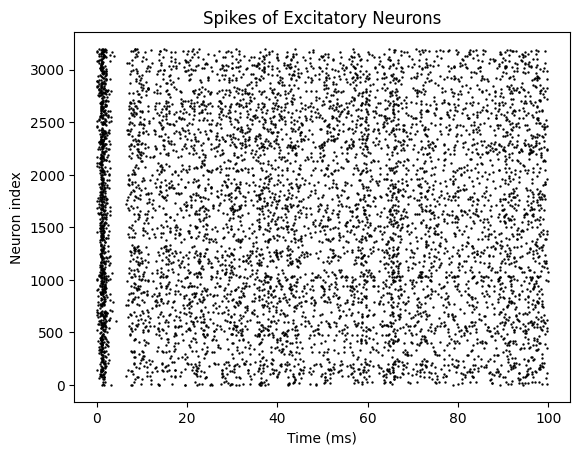

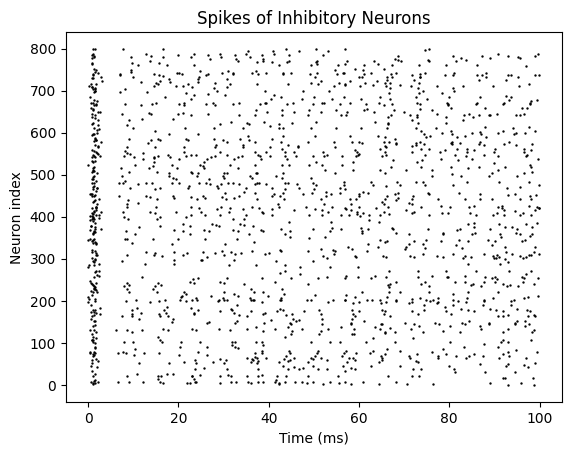

<module 'matplotlib.pyplot' from 'C:\\Users\\adadu\\miniconda3\\envs\\bdp\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [5]:
net = EINet(3200, 800)  # "method": the numerical integrator method
runner = bp.DSRunner(net, monitors=['E.spike', 'I.spike'], inputs=[('Ein.input', 20.), ('Iin.input', 20.)])
runner.run(100.)

# visualization
bp.visualize.raster_plot(runner.mon['ts'], runner.mon['E.spike'],
                         title='Spikes of Excitatory Neurons', show=True)
bp.visualize.raster_plot(runner.mon['ts'], runner.mon['I.spike'],
                         title='Spikes of Inhibitory Neurons', show=True)

## 2. Defining a network with customized ``update()`` function

Another way to instantiate a network model is define a customized update function in which the inputs are customized by the users. For example, 

In [6]:
class EINet2(bp.DynSysGroup):
    def __init__(self, num_exc, num_inh, method='exp_auto'):
        super().__init__()

        # neurons
        pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                    V_initializer=bp.init.Normal(-55., 2.), method=method)
        self.E = bp.dyn.LifRef(num_exc, **pars)
        self.I = bp.dyn.LifRef(num_inh, **pars)

        # Neurons connect to each other randomly with a connection probability of 2%
        self.E2E = Exponential(self.E, self.E, 0.02, g_max=0.6, tau=5., E=0.)
        self.E2I = Exponential(self.E, self.I, 0.02, g_max=0.6, tau=5., E=0.)
        self.I2E = Exponential(self.I, self.E, 0.02, g_max=6.7, tau=10., E=-80.)
        self.I2I = Exponential(self.I, self.I, 0.02, g_max=6.7, tau=10., E=-80.)

    def update(self, inp):
        self.E(inp)  # E and I receive the same input
        self.I(inp)
        self.E2E()
        self.E2I()
        self.I2E()
        self.I2I()

After construction, the simulation goes the same way:

  0%|          | 0/1000 [00:00<?, ?it/s]

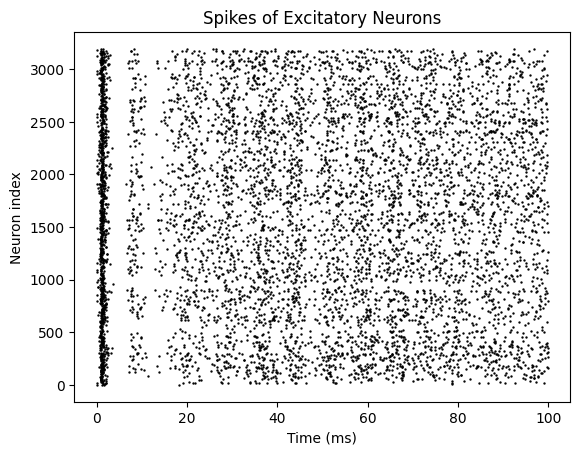

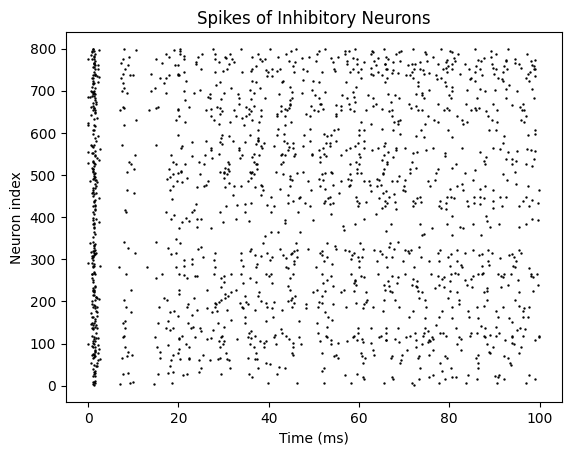

<module 'matplotlib.pyplot' from 'C:\\Users\\adadu\\miniconda3\\envs\\bdp\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [7]:
net2 = EINet2(3200, 800)

inputs = np.ones(int(100. / bm.get_dt())) * 20.  # 100 ms, with the same current of 20
runner = bp.DSRunner(net2, monitors=['E.spike', 'I.spike'])
runner.run(inputs=inputs)

# visualization
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'],
                         title='Spikes of Excitatory Neurons', show=True)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['I.spike'],
                         title='Spikes of Inhibitory Neurons', show=True)